[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


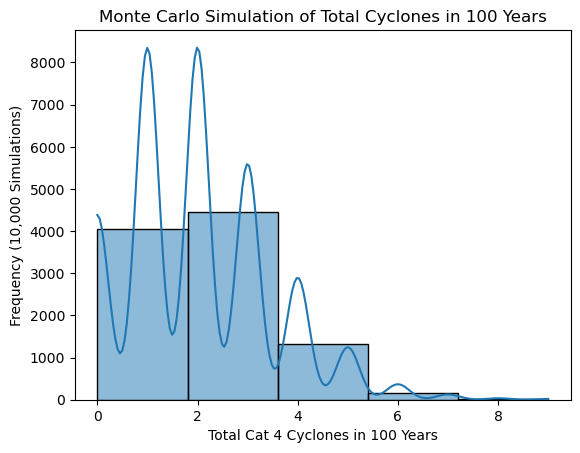

Expected number of cyclones in 100 years: 2.01
Probability of more than 3 cyclones in 100 years: 0.149


In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

lambda_cat4 = 0.02  #occurance of an individual cyclone
years = 100  # Simulate for 100 years
num_simulations = 10000  # Number of Monte Carlo runs

a = np.random.poisson(lambda_cat4, years)
print(a)

total_cyclones = [np.sum(np.random.poisson(lambda_cat4, years)) for _ in range(num_simulations)]

# Plot distribution of total cyclones over 100 years
sns.histplot(total_cyclones, bins=5, kde=True)
plt.xlabel("Total Cat 4 Cyclones in 100 Years")
plt.ylabel("Frequency (10,000 Simulations)")
plt.title("Monte Carlo Simulation of Total Cyclones in 100 Years")
plt.show()

# Compute mean and probability of extreme scenarios
mean_cyclones = np.mean(total_cyclones)
prob_more_than_3 = np.sum(np.array(total_cyclones) > 3) / num_simulations

print(f"Expected number of cyclones in 100 years: {mean_cyclones:.2f}")
print(f"Probability of more than 3 cyclones in 100 years: {prob_more_than_3:.3f}")

# Expected number of cyclones in 100 years: 

In [176]:
from climada.hazard import TCTracks
#load the datasets
tc_hist_ni = TCTracks.from_hdf5('tc_hist_ni.hdf5')
list = tc_hist_ni.subset({'category': 3})


In [177]:
from climada.hazard import TCTracks, TropCyclone, Centroids

list.equal_timestep(
    0.5
)  # Interpolation to make the track smooth and to allow applying calc_perturbed_trajectories
# Add randomly generated tracks using the calc_perturbed_trajectories method (1 per historical track)
list.calc_perturbed_trajectories(nb_synth_tracks=5)
print("num tracks hist+syn:", list.size)

num tracks hist+syn: 72


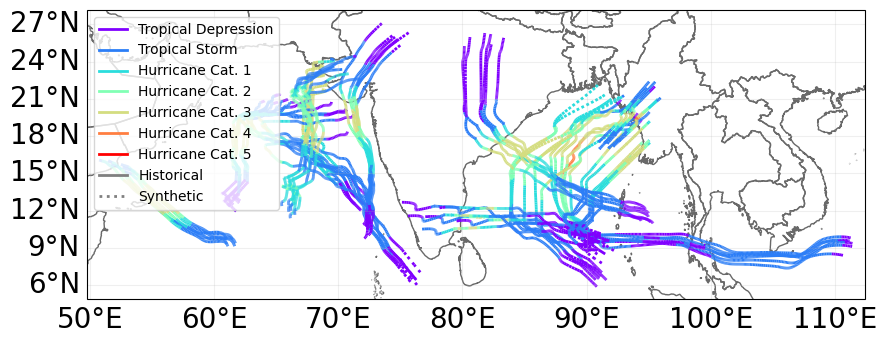

In [ ]:
ax = list.plot()
ax.get_legend()._loc = 2

In [179]:
import pandas as pd
from climada.entity import Exposures

# Define exposrues here
file_name = 'exposures.xlsx'
exposures = pd.read_excel(file_name)

exp  = Exposures(exposures, ref_year=2024)
print(exp)

description: None
ref_year: 2024
value_unit: USD
meta: {'crs': 'EPSG:4326'}
crs: EPSG:4326
data:
    Unnamed: 0   latitude  longitude         value  impf_TC  \
0            1  24.814107  87.135465  1.603000e+09        1   
1            2  21.740068  84.060592  1.890239e+09        1   
2            3  21.080316  77.901242  3.784000e+07        1   
3            4  21.127044  84.980552  4.742700e+08        1   
4            5  20.892474  84.990390  6.069300e+08        1   
..         ...        ...        ...           ...      ...   
90          91  13.237131  80.301754  4.470000e+08        1   
91          92  17.466444  82.961361  8.483000e+07        1   
92          93  17.563642  83.138877  8.920050e+08        1   
93          94  16.708219  79.581184  2.812695e+09        1   
94          95  16.295261  77.356120  2.600000e+08        1   

                           Plant name  
0           Adani Godda power station  
1      Aditya Aluminium power station  
2      Amravati Thermal Po

In [180]:
# Define the centroids from the exposures position
lat = exp.gdf["latitude"].values
lon = exp.gdf["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

In [194]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(list, centroids=centrs)

In [193]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])

In [192]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [191]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True
) # Save the impact in a mat file

print(imp)

In [190]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 2487371.0 $


In [187]:
help(exp.plot_hexbin)

Help on method plot_hexbin in module climada.entity.exposures.base:

plot_hexbin(mask=None, ignore_zero=False, pop_name=True, buffer=0.0, extend='neither', axis=None, figsize=(9, 13), adapt_fontsize=True, title=None, **kwargs) method of climada.entity.exposures.base.Exposures instance
    Plot exposures geometry's value sum binned over Earth's map.
    An other function for the bins can be set through the key reduce_C_function.
    The plot will we projected according to the current crs.
    
    Parameters
    ----------
    mask : np.array, optional
        mask to apply to eai_exp plotted.
    ignore_zero : bool, optional
        flag to indicate if zero and negative
        values are ignored in plot. Default: False
    pop_name : bool, optional
        add names of the populated places, by default True.
    buffer : float, optional
        border to add to coordinates. Default: 0.0.
    extend : str, optional
        extend border colorbar with arrows.
        [ 'neither' | 'both'

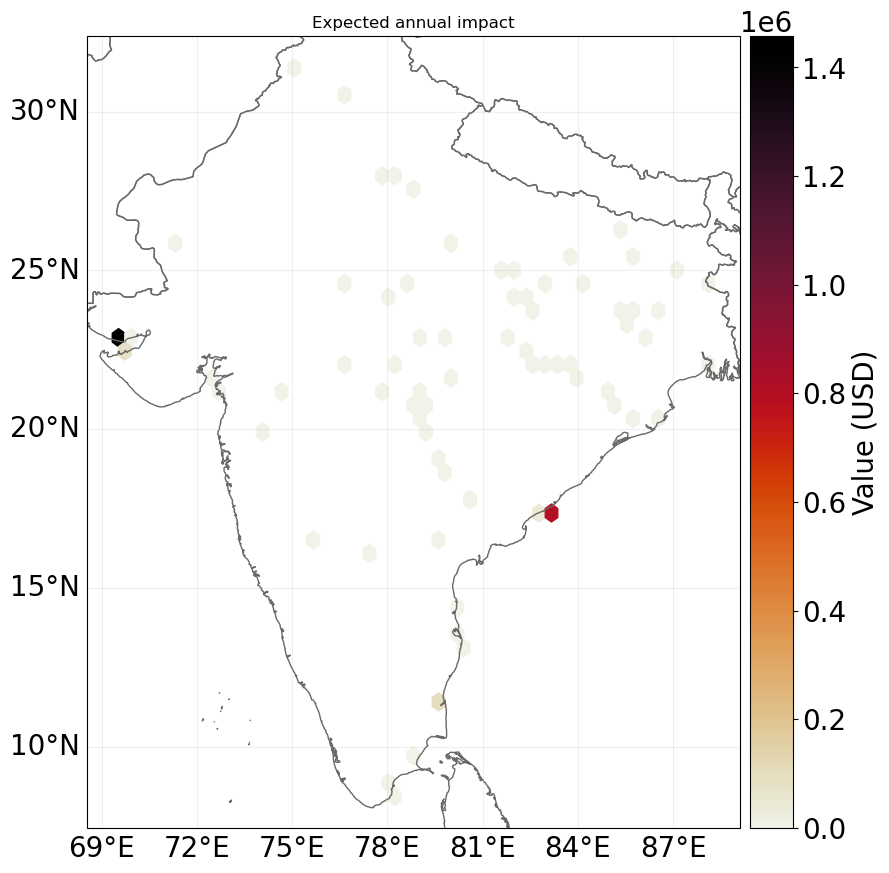

In [188]:
imp.plot_hexbin_eai_exposure(buffer=1, pop_name=False);